In [2]:
from __future__ import division
from functools import partial
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *
from tqdm import tqdm

# Purpose of the Notebook

Cluster Constraint Comparison in:
1. 3(+Mkt)/4-Factor (EM/EM+DM) MVP
2. 3(+Mkt)/4-Factor (EM/EM+DM) RP
3. SR?

# General Framework

1. Find Benchmarket Portfolio: $bm=w\cdot h$
2. Optimize by Objective Function: min $(g-bm)^T V_{country} (g-bm)$ 
 - with Constraint: w_cluster = 0
 - variation on cluster exposure

In [3]:
# find weekly return - take last date and pct-change
country_returns = pd.read_pickle('../Outputs/equity/equity_etf_returns_weekly.pkl')

equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')
equity_factors = equity_factors[equity_factors.momentum.notnull()]

clusters = pd.read_pickle('../Outputs/country_clusters/clusters_equity_etf_full.pkl')
clusters = clusters.groupby('cluster_label')['Countries'].apply(list).to_dict()
equity_clusters = []
for k in clusters.keys():
    ew_returns = country_returns[clusters[k]].mean(axis=1)
    equity_clusters.append(ew_returns)
equity_clusters = pd.concat(equity_clusters,axis=1)
equity_clusters = equity_clusters.loc[equity_factors.index]

In [4]:
cluster = pd.read_pickle('../Outputs/country_clusters/clusters_equity_etf_full.pkl')
cluster_map = cluster.set_index('Countries').to_dict()['cluster_label']

In [5]:
def obj_(g, V, bm):
#     bm = bm.values.reshape(bm.shape[0],1)
#     bm = np.repeat(bm,g.shape[0],axis=1)
    bm = bm.mean()
    return (g-bm) @ V @ (g-bm).T

def cluster_constraints(returns, cluster_map):
    cmap = returns.columns.map(cluster_map)
    cmap = np.matrix([(cmap==c)*1 for c in cmap.unique()]).T
    lb = np.repeat(np.matrix([0.]),4,axis=1)
    ub = np.repeat(np.matrix([0.01]),4,axis=1) # upper and lower bounds
    group_cons = list()
    lb, ub = 0., 0.01
    lbdict = {'type': 'ineq', 
              'fun': lambda x: np.sum(np.sum(x*cmap,axis=1) - lb)}
    ubdict = {'type': 'ineq', 
              'fun': lambda x: np.sum(ub-np.sum(x*cmap,axis=1))}
    group_cons.append(lbdict); group_cons.append(ubdict)
    return group_cons

def opt(cntry_rtn,V,bm,cons = True):    
    noa = len(cntry_rtn.columns)
    guess = noa * [1. / noa,] # equal-weight for initial guess

    if cons:
        cmap = cntry_rtn.columns.map(cluster_map)
        lb = 0
        ub = 0.01
        cons = [
                {'type': 'ineq', 
                  'fun': lambda x: np.sum(x[cmap==0])-lb},
                {'type': 'ineq', 
                  'fun': lambda x: np.sum(x[cmap==1])-lb},
                {'type': 'ineq', 
                  'fun': lambda x: np.sum(x[cmap==2])-lb},
                {'type': 'ineq', 
                  'fun': lambda x: ub-np.sum(x[cmap==0])},
                {'type': 'ineq', 
                      'fun': lambda x: ub-np.sum(x[cmap==1])},
                {'type': 'ineq', 
                      'fun': lambda x: ub-np.sum(x[cmap==2])}]
        #{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.},

        if noa ==4:
            cons.append({'type': 'ineq', 
                          'fun': lambda x: np.sum(x[cmap==3])-lb}) 
            cons.append({'type': 'ineq', 
                          'fun': lambda x: ub-np.sum(x[cmap==3])})
    else:
        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.}]
        
    opt = minimize(obj_, guess, args=(V,bm), method='SLSQP', 
                   constraints=cons, tol=1e-10)
    return opt.x

def opt_multi(cntry_rtn, bm, cons = True, window = 52):
    dates = cntry_rtn.index
    w_ = []
    for d in tqdm(range(len(dates)-window)):
        date_idx = dates[d:d+window+1]
        try:
            bm_t = bm.loc[date_idx]
            cnt_t = cntry_rtn.loc[date_idx]
            v_t = cnt_t.cov()
            res = opt(cnt_t,v_t,bm_t,cons)
            w_.append(res)
        except:
            continue
    w_ = np.matrix(w_)
    final_w = pd.DataFrame(w_,columns = cntry_rtn.columns, index = dates[-w_.shape[0]:])
    return final_w

# 1. MVP Comparison

In [6]:
# # benchmarks
all_mvp = pd.read_pickle('all_mvp.pickle')
all_mvp.columns

Index(['Country', 'Cluster', '4-Factor (BAB)', '4-Factor (Mkt)', '3-Factor',
       '3-Factor+Mkt', 'DM 4-Factor (BAB)', 'DM 3-Factor+Mkt', 'DM 3-Factor'],
      dtype='object')

### 4-Factor BAB

In [7]:
mv_f4bab_cons_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['4-Factor (BAB)'])

100%|██████████| 120/120 [01:55<00:00,  1.04it/s]


In [8]:
mv_f4bab_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['4-Factor (BAB)'],cons=False)

100%|██████████| 120/120 [01:40<00:00,  1.19it/s]


Text(0.5, 1.0, 'Cluster Constrained 4-Factor (BAB) Country Portfolio Performance 2018-2021')

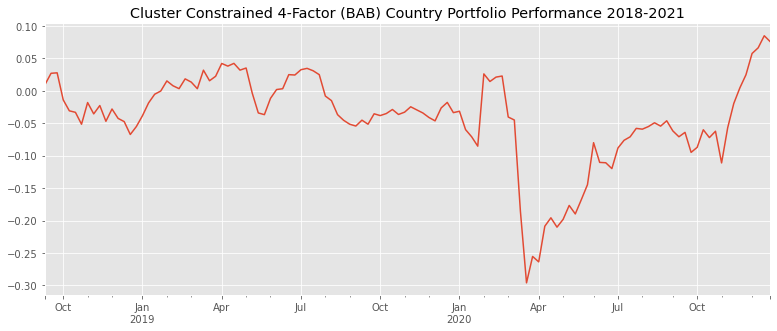

In [9]:
mv_f4bab_cons_w1 = mv_f4bab_cons_w.divide(mv_f4bab_cons_w.sum(axis=1),axis=0)
mv_f4bab_cons_ret1 = (mv_f4bab_cons_w1 * country_returns.loc[mv_f4bab_cons_w.index]).sum(axis=1)
(np.cumprod(1 + mv_f4bab_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 4-Factor (BAB) Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 4-Factor (BAB) Country Portfolio Performance 2018-2021')

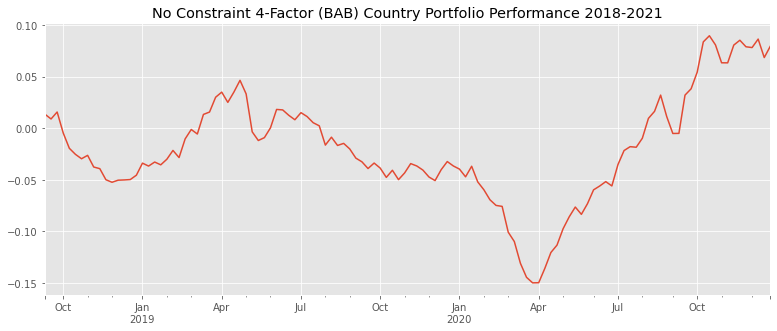

In [10]:
mv_f4bab_w1 = mv_f4bab_w.divide(mv_f4bab_w.sum(axis=1),axis=0)
mv_f4bab_ret1 = (mv_f4bab_w1 * country_returns.loc[mv_f4bab_w.index]).sum(axis=1)
(np.cumprod(1 + mv_f4bab_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 4-Factor (BAB) Country Portfolio Performance 2018-2021')

### 3 Factor + Mkt

In [11]:
mv_f3_cons_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['3-Factor+Mkt'])

100%|██████████| 120/120 [01:47<00:00,  1.12it/s]


In [12]:
mv_f3_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['3-Factor+Mkt'],cons=False)

100%|██████████| 120/120 [01:36<00:00,  1.25it/s]


Text(0.5, 1.0, 'Cluster Constrained 3-Factor + Mkt Country Portfolio Performance 2018-2021')

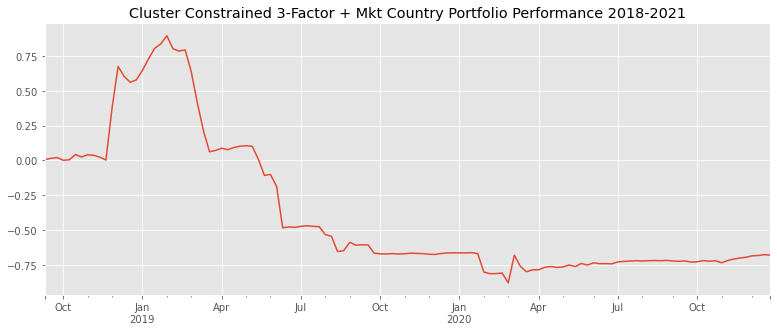

In [15]:
mv_f3_cons_w1 = mv_f3_cons_w.divide(mv_f3_cons_w.sum(axis=1),axis=0)
mv_f3_cons_ret1 = (mv_f3_cons_w1 * country_returns.loc[mv_f3_cons_w.index]).sum(axis=1)
(np.cumprod(1 + mv_f3_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 3-Factor + Mkt Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'Cluster Constrained 3-Factor + Mkt Country Portfolio Performance 2018-2021')

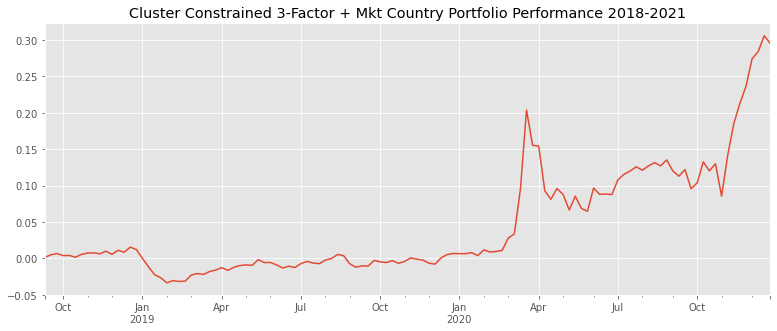

In [36]:
mv_f3_cons_w2 = mv_f3_cons_w.divide(mv_f3_cons_w.abs().sum(axis=1),axis=0)
mv_f3_cons_ret2 = (mv_f3_cons_w2 * country_returns.loc[mv_f3_cons_w.index]).sum(axis=1)
(np.cumprod(1 + mv_f3_cons_ret2)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 3-Factor + Mkt Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 3-Factor + Mkt Country Portfolio Performance 2018-2021')

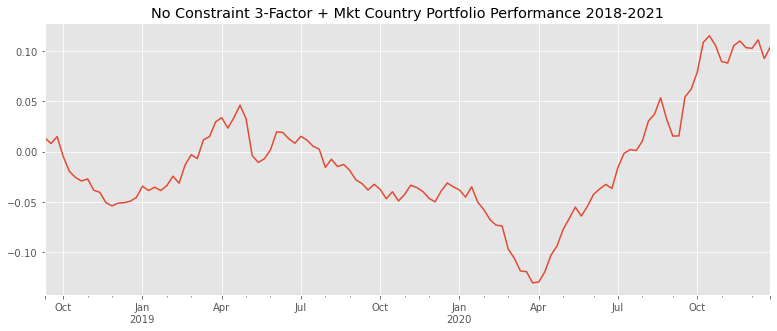

In [16]:
mv_f3_w1 = mv_f3_w.divide(mv_f3_w.sum(axis=1),axis=0)
mv_f3_ret1 = (mv_f3_w1 * country_returns.loc[mv_f3_w.index]).sum(axis=1)
(np.cumprod(1 + mv_f3_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 3-Factor + Mkt Country Portfolio Performance 2018-2021')

### DM 4-Factor BAB

In [17]:
dm_mv_f4bab_cons_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['DM 4-Factor (BAB)'])

100%|██████████| 120/120 [01:50<00:00,  1.09it/s]


In [18]:
dm_mv_f4bab_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['DM 4-Factor (BAB)'],cons=False)

100%|██████████| 120/120 [01:36<00:00,  1.24it/s]


Text(0.5, 1.0, 'Cluster Constrained 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

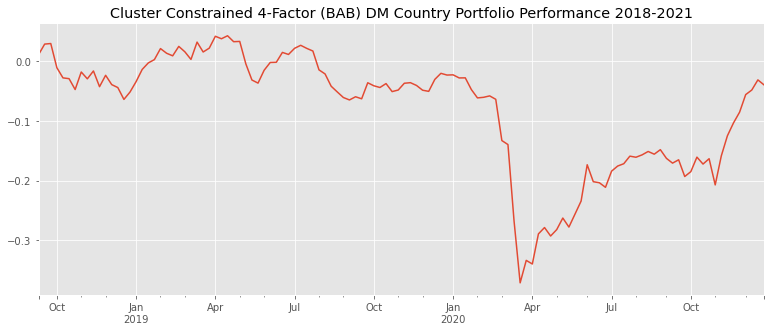

In [19]:
dm_mv_f4bab_cons_w1 = dm_mv_f4bab_cons_w.divide(dm_mv_f4bab_cons_w.sum(axis=1),axis=0)
dm_mv_f4bab_cons_ret1 = (dm_mv_f4bab_cons_w1 * country_returns.loc[dm_mv_f4bab_cons_w.index]).sum(axis=1)
(np.cumprod(1 + dm_mv_f4bab_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

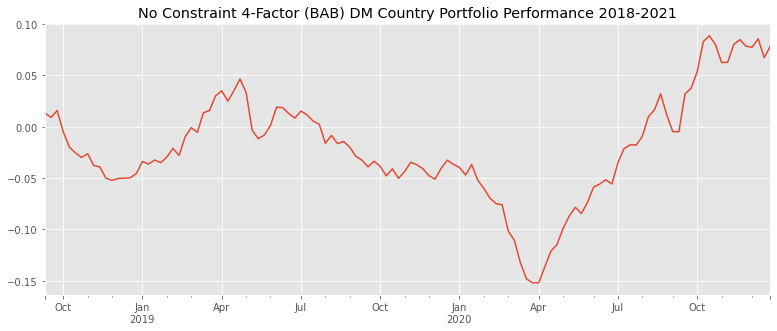

In [20]:
dm_mv_f4bab_w1 = dm_mv_f4bab_w.divide(dm_mv_f4bab_w.sum(axis=1),axis=0)
dm_mv_f4bab_ret1 = (dm_mv_f4bab_w1 * country_returns.loc[dm_mv_f4bab_w.index]).sum(axis=1)
(np.cumprod(1 + dm_mv_f4bab_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

### DM 3 Factor + Mkt

In [21]:
dm_mv_f3_cons_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['DM 3-Factor+Mkt'])

100%|██████████| 120/120 [01:51<00:00,  1.08it/s]


In [22]:
dm_mv_f3_w  = opt_multi(country_returns.loc[all_mvp.index],all_mvp['DM 3-Factor+Mkt'],cons=False)

100%|██████████| 120/120 [01:35<00:00,  1.25it/s]


Text(0.5, 1.0, 'Cluster Constrained 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

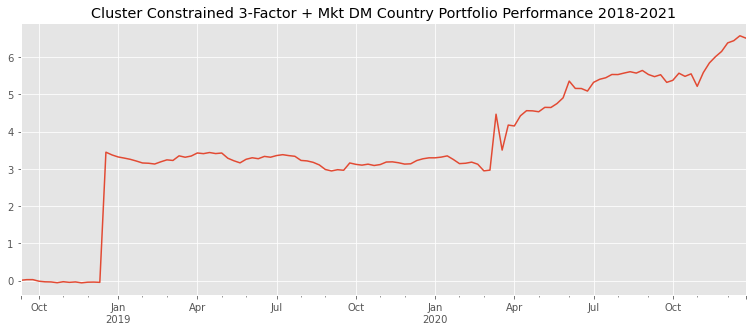

In [23]:
dm_mv_f3_cons_w1 = dm_mv_f3_cons_w.divide(dm_mv_f3_cons_w.sum(axis=1),axis=0)
dm_mv_f3_cons_ret1 = (dm_mv_f3_cons_w1 * country_returns.loc[dm_mv_f3_cons_w.index]).sum(axis=1)
(np.cumprod(1 + dm_mv_f3_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'Cluster Constrained 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

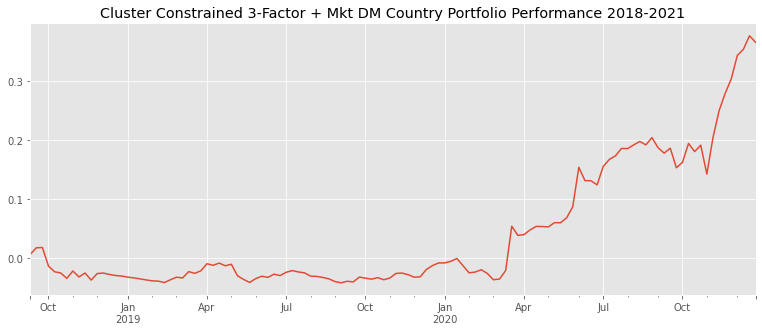

In [33]:
dm_mv_f3_cons_w2 = dm_mv_f3_cons_w.divide(dm_mv_f3_cons_w.abs().sum(axis=1),axis=0)
dm_mv_f3_cons_ret2 = (dm_mv_f3_cons_w2 * country_returns.loc[dm_mv_f3_cons_w.index]).sum(axis=1)
(np.cumprod(1 + dm_mv_f3_cons_ret2)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

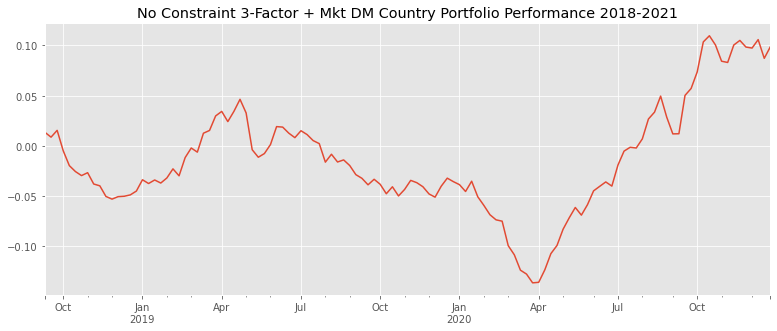

In [24]:
dm_mv_f3_w1 = dm_mv_f3_w.divide(dm_mv_f3_w.sum(axis=1),axis=0)
dm_mv_f3_ret1 = (dm_mv_f3_w1 * country_returns.loc[dm_mv_f3_w.index]).sum(axis=1)
(np.cumprod(1 + dm_mv_f3_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

# 2. RP Comparison

In [49]:
# # benchmarks
all_rp = pd.read_pickle('all_rp.pickle')
all_rp.columns

Index(['Country', 'Cluster', '4-Factor (Mkt)', '4-Factor (BAB)',
       '3-Factor+Mkt', 'DM 4-Factor (BAB)', 'DM 3-Factor+Mkt'],
      dtype='object')

### 4-Factor BAB

In [35]:
f4bab_cons_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['4-Factor (BAB)'])

100%|██████████| 163/163 [02:30<00:00,  1.09it/s]


In [41]:
f4bab_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['4-Factor (BAB)'],cons=False)

100%|██████████| 163/163 [02:03<00:00,  1.32it/s]


Text(0.5, 1.0, 'Cluster Constrained 4-Factor (BAB) Country Portfolio Performance 2018-2021')

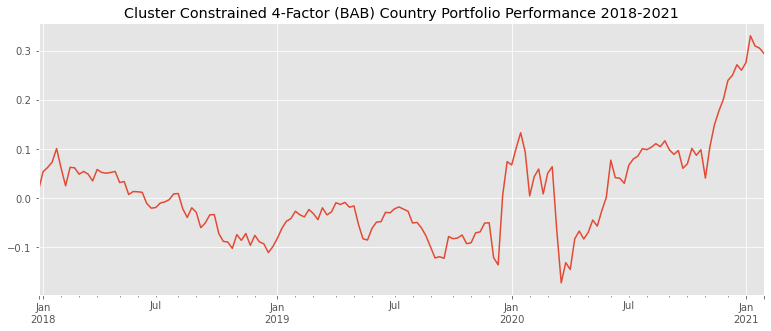

In [12]:
f4bab_cons_w1 = f4bab_cons_w.divide(f4bab_cons_w.sum(axis=1),axis=0)
f4bab_cons_ret1 = (f4bab_cons_w1 * country_returns.loc[f4bab_cons_w.index]).sum(axis=1)
(np.cumprod(1 + f4bab_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 4-Factor (BAB) Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 4-Factor (BAB) Country Portfolio Performance 2018-2021')

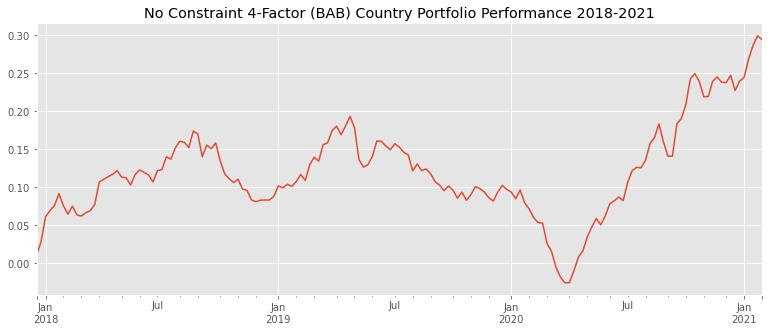

In [42]:
f4bab_w1 = f4bab_w.divide(f4bab_w.sum(axis=1),axis=0)
f4bab_ret1 = (f4bab_w1 * country_returns.loc[f4bab_w.index]).sum(axis=1)
(np.cumprod(1 + f4bab_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 4-Factor (BAB) Country Portfolio Performance 2018-2021')

### 3 Factor + Mkt

In [50]:
f3_cons_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['3-Factor+Mkt'])

100%|██████████| 163/163 [02:29<00:00,  1.09it/s]


In [52]:
f3_cons_w = f3bab_cons_w
f3_w = f3bab_w

In [51]:
f3_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['3-Factor+Mkt'],cons=False)

100%|██████████| 163/163 [02:02<00:00,  1.33it/s]


Text(0.5, 1.0, 'Cluster Constrained 3-Factor + Mkt Country Portfolio Performance 2018-2021')

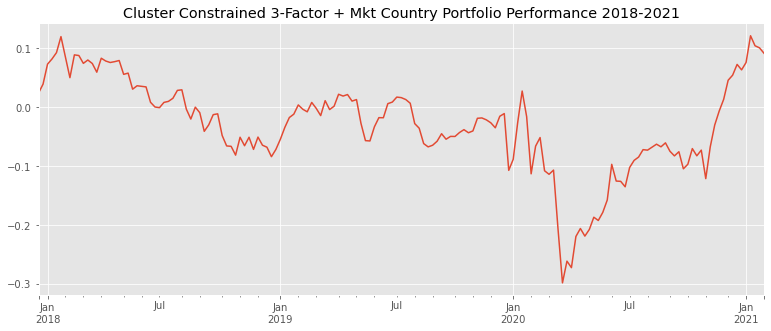

In [53]:
f3_cons_w1 = f3_cons_w.divide(f3_cons_w.sum(axis=1),axis=0)
f3_cons_ret1 = (f3_cons_w1 * country_returns.loc[f3_cons_w.index]).sum(axis=1)
(np.cumprod(1 + f3_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 3-Factor + Mkt Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 3-Factor + Mkt Country Portfolio Performance 2018-2021')

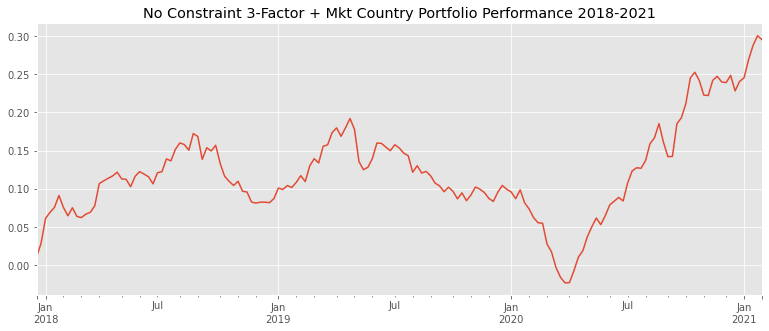

In [54]:
f3_w1 = f3_w.divide(f3_w.sum(axis=1),axis=0)
f3_ret1 = (f3_w1 * country_returns.loc[f3_w.index]).sum(axis=1)
(np.cumprod(1 + f3_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 3-Factor + Mkt Country Portfolio Performance 2018-2021')

### DM 4-Factor BAB

In [55]:
dm_f4bab_cons_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['DM 4-Factor (BAB)'])

100%|██████████| 163/163 [02:28<00:00,  1.10it/s]


In [56]:
dm_f4bab_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['DM 4-Factor (BAB)'],cons=False)

100%|██████████| 163/163 [02:03<00:00,  1.33it/s]


Text(0.5, 1.0, 'Cluster Constrained 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

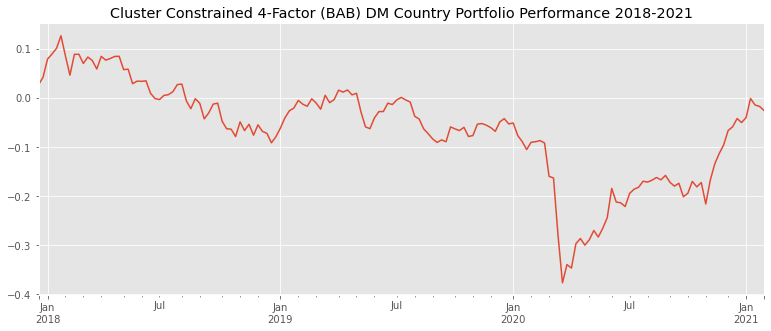

In [57]:
dm_f4bab_cons_w1 = dm_f4bab_cons_w.divide(dm_f4bab_cons_w.sum(axis=1),axis=0)
dm_f4bab_cons_ret1 = (dm_f4bab_cons_w1 * country_returns.loc[dm_f4bab_cons_w.index]).sum(axis=1)
(np.cumprod(1 + dm_f4bab_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

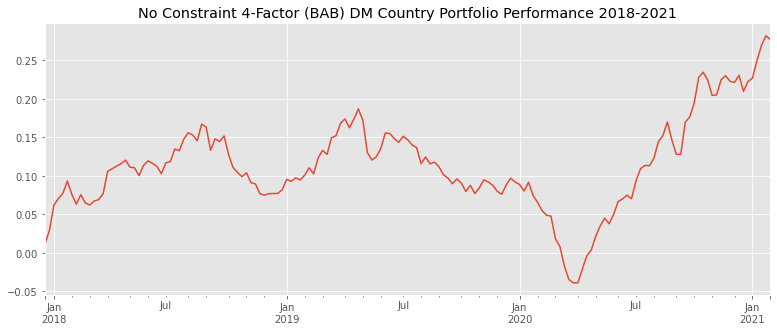

In [64]:
dm_f4bab_w1 = dm_f4bab_w.divide(dm_f4bab_w.sum(axis=1),axis=0)
dm_f4bab_ret1 = (dm_f4bab_w1 * country_returns.loc[dm_f4bab_w.index]).sum(axis=1)
(np.cumprod(1 + dm_f4bab_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 4-Factor (BAB) DM Country Portfolio Performance 2018-2021')

### DM 3 Factor + Mkt

In [76]:
dm_f3_cons_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['DM 3-Factor+Mkt'])

100%|██████████| 163/163 [02:26<00:00,  1.11it/s]


In [77]:
dm_f3_w  = opt_multi(country_returns.loc[all_rp.index],all_rp['DM 3-Factor+Mkt'],cons=False)

100%|██████████| 163/163 [02:03<00:00,  1.32it/s]


Text(0.5, 1.0, 'Cluster Constrained 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

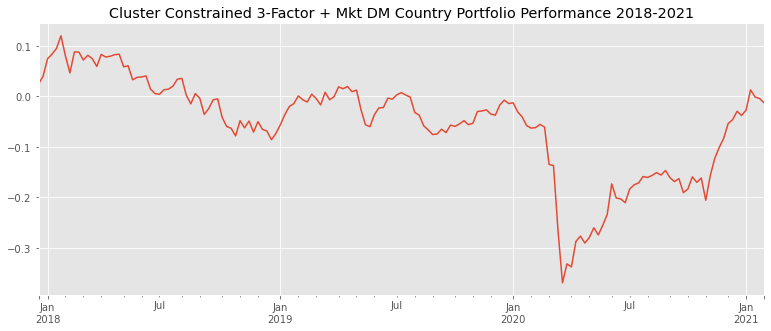

In [78]:
dm_f3_cons_w1 = dm_f3_cons_w.divide(dm_f3_cons_w.sum(axis=1),axis=0)
dm_f3_cons_ret1 = (dm_f3_cons_w1 * country_returns.loc[dm_f3_cons_w.index]).sum(axis=1)
(np.cumprod(1 + dm_f3_cons_ret1)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

Text(0.5, 1.0, 'No Constraint 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

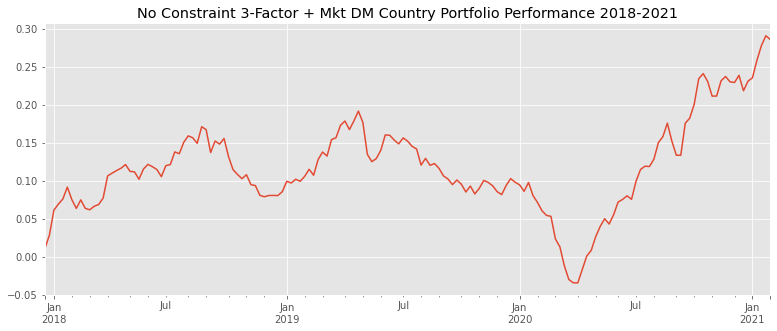

In [79]:
dm_f3_w1 = dm_f3_w.divide(dm_f3_w.sum(axis=1),axis=0)
dm_f3_ret1 = (dm_f3_w1 * country_returns.loc[dm_f3_w.index]).sum(axis=1)
(np.cumprod(1 + dm_f3_ret1)-1).plot(figsize = (13,5))
plt.title('No Constraint 3-Factor + Mkt DM Country Portfolio Performance 2018-2021')

# Comparison

In [37]:
# MVP
portfolios = [mv_f4bab_cons_ret1, mv_f4bab_ret1, 
              mv_f3_cons_ret2, mv_f3_ret1,
              dm_mv_f4bab_cons_ret1, dm_mv_f4bab_ret1, 
              dm_mv_f3_cons_ret2, dm_mv_f3_ret1,]
all_mvp_cons = pd.concat(portfolios,axis=1)
all_mvp_cons.columns = ['4-Factor (BAB) Constrained','4-Factor (BAB)',
                 '3-Factor + Mkt Constrained','3-Factor + Mkt',
                 'DM 4-Factor (BAB) Constrained','DM 4-Factor (BAB)',
                 'DM 3-Factor + Mkt Constrained','DM 3-Factor + Mkt']

perf_df = {}
for c in all_mvp_cons:
    res = calc_performance(all_mvp_cons[c].dropna(), log_ret = False, time = 52,mkt=equity_factors['market-rf'])
    perf_df[c] = res

dfidx = ['Ann Return','Ann Std','Ann SR',
         'Skewness','Kurtosis','Max Drawdown','Max DD Date', 'Market Beta', 'Market Correlation']
perf_df = pd.DataFrame(perf_df, index = dfidx)
print('Mean Variance Portfolios')
perf_df

Mean Variance Portfolios


,4-Factor (BAB) Constrained,4-Factor (BAB),3-Factor + Mkt Constrained,3-Factor + Mkt,DM 4-Factor (BAB) Constrained,DM 4-Factor (BAB),DM 3-Factor + Mkt Constrained,DM 3-Factor + Mkt
Ann Return,3.21,3.37,11.86,4.38,-1.75,3.33,14.47,4.16
Ann Std,22.03,8.36,11.74,8.19,20.94,8.41,10.63,8.23
Ann SR,0.15,0.4,1.01,0.53,-0.08,0.4,1.36,0.51
Skewness,-1.44,-0.07,1.67,0.01,-2.19,-0.09,1.61,-0.02
Kurtosis,10.23,0.61,11.61,0.65,11.81,0.59,7.54,0.65
Max Drawdown,32.47,18.77,11.56,16.87,39.66,18.98,5.89,17.46
Max DD Date,2020-03-22,2020-03-29,2020-05-31,2020-03-29,2020-03-22,2020-04-05,2019-09-08,2020-03-29
Market Beta,0.761,0.171,-0.169,0.124,0.849,0.18,0.122,0.142
Market Correlation,0.766,0.462,-0.33,0.342,0.888,0.484,0.262,0.391


In [41]:
pd.read_html(html,index_col=0)[0].T

,Ann Return,Ann Std,Ann SR,Skewness,Kurtosis,Max Drawdown,Max DD Date,Market Beta,Market Correlation
4-Factor (BAB) Constrained,3.21,22.03,0.15,-1.44,10.23,32.47,2020-03-22,0.761,0.766
4-Factor (BAB),3.37,8.36,0.4,-0.07,0.61,18.77,2020-03-29,0.171,0.462
3-Factor + Mkt Constrained,11.86,11.74,1.01,1.67,11.61,11.56,2020-05-31,-0.169,-0.33
3-Factor + Mkt,4.38,8.19,0.53,0.01,0.65,16.87,2020-03-29,0.124,0.342
DM 4-Factor (BAB) Constrained,-1.75,20.94,-0.08,-2.19,11.81,39.66,2020-03-22,0.849,0.888
DM 4-Factor (BAB),3.33,8.41,0.4,-0.09,0.59,18.98,2020-04-05,0.18,0.484
DM 3-Factor + Mkt Constrained,14.47,10.63,1.36,1.61,7.54,5.89,2019-09-08,0.122,0.262
DM 3-Factor + Mkt,4.16,8.23,0.51,-0.02,0.65,17.46,2020-03-29,0.142,0.391


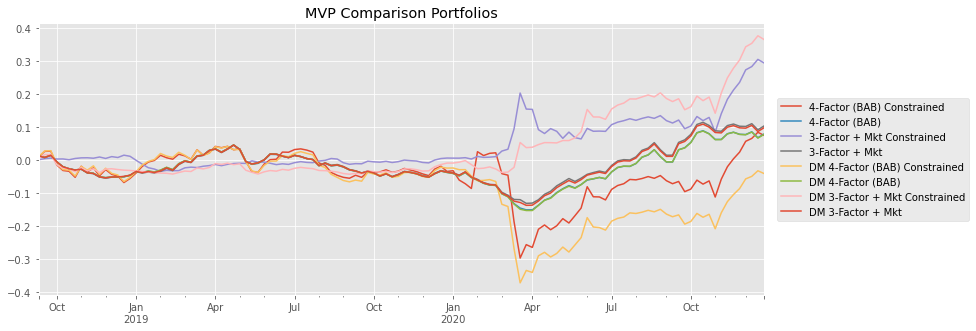

In [38]:
((1+all_mvp_cons.dropna()).cumprod()-1).plot(figsize=(13,5), title = 'MVP Comparison Portfolios')
plt.legend(bbox_to_anchor=[1.15, 0.5], loc='center');

In [82]:
# RP
portfolios = [f4bab_cons_ret1, f4bab_ret1, 
              f3_cons_ret1, f3_ret1,
              dm_f4bab_cons_ret1, dm_f4bab_ret1, 
              dm_f3_cons_ret1, dm_f3_ret1,]
all_rp_cons = pd.concat(portfolios,axis=1)
all_rp_cons.columns = ['4-Factor (BAB) Constrained','4-Factor (BAB)',
                 '3-Factor + Mkt Constrained','3-Factor + Mkt',
                 'DM 4-Factor (BAB) Constrained','DM 4-Factor (BAB)',
                 'DM 3-Factor + Mkt Constrained','DM 3-Factor + Mkt']

perf_df = {}
for c in all_sr:
    res = calc_performance1(all_rp_cons[c].dropna(), log_ret = False, time = 52,mkt=equity_factors['market-rf'])
    perf_df[c] = res

dfidx = ['Ann Return','Ann Std','Ann SR',
         'Skewness','Kurtosis','Max Drawdown','Max DD Date', 'Market Beta', 'Market Correlation']
perf_df = pd.DataFrame(perf_df, index = dfidx)
print('Risk Parity Portfolios')
perf_df

Risk Parity Portfolios


,4-Factor (BAB) Constrained,4-Factor (BAB),3-Factor + Mkt Constrained,3-Factor + Mkt,DM 4-Factor (BAB) Constrained,DM 4-Factor (BAB),DM 3-Factor + Mkt Constrained,DM 3-Factor + Mkt
Ann Return,8.63,8.57,2.85,8.61,-0.84,8.11,-0.41,8.34
Ann Std,21.83,8.26,20.03,8.27,19.15,8.41,19.27,8.38
Ann SR,0.4,1.04,0.14,1.04,-0.04,0.96,-0.02,1.0
Skewness,-0.2,-0.04,-1.3,-0.05,-1.78,-0.1,-2.14,-0.1
Kurtosis,6.78,0.53,5.31,0.57,10.13,0.53,12.57,0.57
Max Drawdown,26.98,18.34,37.38,18.09,44.72,19.03,43.71,18.96
Max DD Date,2020-03-22,2020-03-29,2020-03-22,2020-03-29,2020-03-22,2020-04-05,2020-03-22,2020-04-05
Market Beta,0.703,0.184,0.757,0.185,0.759,0.201,0.787,0.2
Market Correlation,0.714,0.491,0.82,0.495,0.856,0.528,0.878,0.526


In [45]:
pd.read_html(html,index_col=0)[0].T

,Ann Return,Ann Std,Ann SR,Skewness,Kurtosis,Max Drawdown,Max DD Date,Market Beta,Market Correlation
4-Factor (BAB) Constrained,8.63,21.83,0.4,-0.2,6.78,26.98,2020-03-22,0.703,0.714
4-Factor (BAB),8.57,8.26,1.04,-0.04,0.53,18.34,2020-03-29,0.184,0.491
3-Factor + Mkt Constrained,2.85,20.03,0.14,-1.3,5.31,37.38,2020-03-22,0.757,0.82
3-Factor + Mkt,8.61,8.27,1.04,-0.05,0.57,18.09,2020-03-29,0.185,0.495
DM 4-Factor (BAB) Constrained,-0.84,19.15,-0.04,-1.78,10.13,44.72,2020-03-22,0.759,0.856
DM 4-Factor (BAB),8.11,8.41,0.96,-0.1,0.53,19.03,2020-04-05,0.201,0.528
DM 3-Factor + Mkt Constrained,-0.41,19.27,-0.02,-2.14,12.57,43.71,2020-03-22,0.787,0.878
DM 3-Factor + Mkt,8.34,8.38,1.0,-0.1,0.57,18.96,2020-04-05,0.2,0.526


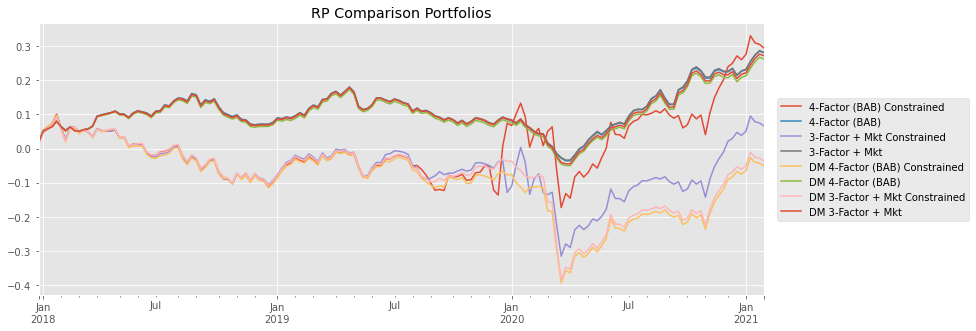

In [86]:
((1+all_rp_cons.dropna()).cumprod()-1).plot(figsize=(13,5), title = 'RP Comparison Portfolios')
plt.legend(bbox_to_anchor=[1.15, 0.5], loc='center');

In [87]:
all_rp_cons.to_pickle('all_rp_cons.pickle')

In [39]:
all_mvp_cons.to_pickle('all_mvp_cons.pickle')